In [1]:
import logging
import os
import sys
from itertools import product
from pathlib import Path
from typing import Dict, List, Optional

import IPython
import matplotlib
from seaborn._statistics import LetterValues
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import textalloc as ta
from tqdm import tqdm

NOTEBOOK_PATH: Path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
PROJECT_DIR: Path = NOTEBOOK_PATH.parent.parent
sys.path.append(str(PROJECT_DIR))
import src.utils.custom_log as custom_log
from src._StandardNames import StandardNames
from src.load.LoadForClassification import RENAMER, LoadForClassification
from src.utils.PathChecker import PathChecker
from src.utils.set_rcparams import set_rcparams
import src.utils.json_util as json_util

os.chdir(PROJECT_DIR)
set_rcparams()

LOG: logging.Logger = logging.getLogger(__name__)
custom_log.init_logger(log_lvl=logging.INFO)
LOG.info("Log start, project directory is %s (exist: %s)", PROJECT_DIR, PROJECT_DIR.is_dir())

CHECK: PathChecker = PathChecker()
STR: StandardNames = StandardNames()

FIG_DIR: Path = CHECK.check_directory(PROJECT_DIR / "reports" / "figures", exit=False)
FIG_DIR /= NOTEBOOK_PATH.stem
FIG_DIR.mkdir(parents=True, exist_ok=True)
LOG.info("Figure directory is %s (exist: %s)", FIG_DIR, FIG_DIR.is_dir())

DATA_DIR: Path = CHECK.check_directory(PROJECT_DIR / "data" / "doe" / "doe_sobol_20240705_194200", exit=False)
INJ_FPATH: Path = CHECK.check_file(DATA_DIR / "injury_criteria.parquet", exit=False)
CLASSES_FPATHS: Dict[int, Path] = {
    i: CHECK.check_file(DATA_DIR / f"injury_criteria_classes_{i}.parquet", exit=False) for i in (2, 3, 5, 7)
}
CHANNELS_FPATH: Path = CHECK.check_file(DATA_DIR / "channels.parquet", exit=False)
DOE_FPATH: Path = CHECK.check_file(DATA_DIR / "doe_combined.parquet", exit=False)
SIMID2ID_FPATH: Path = CHECK.check_file(DATA_DIR / "sim_id_2_id.parquet", exit=False)

2025-01-04 11:39:05,611     INFO  MainProcess  MainThread Log start, project directory is /root/py_projects/aihiii (exist: True)
2025-01-04 11:39:05,612     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/reports/figures' exists
2025-01-04 11:39:05,613     INFO  MainProcess  MainThread Figure directory is /root/py_projects/aihiii/reports/figures/analyze_injury_data_sobol_final (exist: True)
2025-01-04 11:39:05,613     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200' exists
2025-01-04 11:39:05,614     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists
2025-01-04 11:39:05,615     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200/injury_criteria_classes_2.parquet' exists
2025-01-04 11:39:05,615     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200/injur

In [6]:
INJURIES: List[str] = [
    "Head_HIC15",
    "Head_a3ms",
    "Neck_My_Extension",
    "Neck_Fz_Max_Tension",
    "Neck_Fx_Shear_Max",
    "Chest_a3ms",
    "Chest_Deflection",
    "Chest_VC",
    "Femur_Fz_Max_Compression",
]
INJ_NAMES: Dict[str, str] = {
    "Head_HIC15": "Head HIC$_{15}$",
    "Head_a3ms": "Head HAC$_3$",
    "Neck_My_Extension": "Neck NEC",
    "Neck_Fz_Max_Tension": "Neck NTC",
    "Neck_Fx_Shear_Max": "Neck NSC",
    "Chest_a3ms": "Chest CAC$_3$",
    "Chest_Deflection": "Chest CDC",
    "Chest_VC": "Chest CVC",
    "Femur_Fz_Max_Compression": "Femur FCC",
}
WIDTH = 448.13095 / 72 -0.2

In [8]:
def save_fig(fig: matplotlib.figure.Figure, f_name: str, close=True) -> None:
    f_path = FIG_DIR / f_name
    fig.savefig(f_path.with_suffix(".pdf"), transparent=False)
    LOG.info("Saved figure to %s", f_path)
    if close:
        plt.close(fig)

In [22]:
def single_box_and_rug(inj_val: str, perc: int, ax, drop_ids: Optional[Dict[int, List[int]]] = None):
    filters = [(STR.perc, "==", perc)]
    if drop_ids is not None:
        filters += [(STR.id, "not in", drop_ids[perc])]

    db: pd.DataFrame = pd.read_parquet(INJ_FPATH, columns=[inj_val], filters=tuple(filters))[inj_val].droplevel(STR.perc)


    # base plot
    sns.rugplot(x=db, ax=ax, height=0.05)
    sns.boxenplot(
        x=db,
        ax=ax,
        fill=False,
        color=".5",
        linecolor="#137",
        flier_kws={"s": 0.2},
    )

    # extreme outlier
    if drop_ids is None:
        q1, q3 = db.quantile([0.25, 0.75])
        iqr = q3 - q1
        db_extreme = db[db.le(q1 - 3 * iqr) | db.ge(q3 + 3 * iqr)]
        if len(db_extreme) > 0:
            ax.scatter(
                db_extreme,
                [0] * len(db_extreme),
                color="r",
                marker="x",
                s=0.7,
                alpha=0.5,
            )
        
        fliers = LetterValues(k_depth="tukey", outlier_prop=0.007, trust_alpha=0.05)(db.values)["fliers"]
        if inj_val != "Chest_Deflection" or perc != 5:
            fliers = [x for x in fliers if x > db.mean()]
        idx = pd.Index(db.values)
        idx = [int(db.index[idx.get_loc(x)]) for x in fliers]

        ta.allocate(
                ax=ax,
                y=[0] * len(fliers),
                x=fliers,
                text_list=idx,
                y_scatter=[0] * len(fliers),
                x_scatter=fliers,
                min_distance=0.1,
                linecolor="g",
                linewidth=0.2,
                textsize=5,
                nbr_candidates=1000,
                avoid_label_lines_overlap=True,
            )

100%|██████████| 27/27 [01:49<00:00,  4.07s/it]
2025-01-04 12:44:43,114     INFO  MainProcess  MainThread maxp pruned
2025-01-04 12:44:43,132     INFO  MainProcess  MainThread cmap pruned
2025-01-04 12:44:43,134     INFO  MainProcess  MainThread kern dropped
2025-01-04 12:44:43,135     INFO  MainProcess  MainThread post pruned
2025-01-04 12:44:43,136     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 12:44:43,141     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 12:44:43,154     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 12:44:43,171     INFO  MainProcess  MainThread glyf pruned
2025-01-04 12:44:43,174     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 12:44:43,176     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 12:44:43,176     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 7 glyphs before
2025-01-04 12:44:43,177     INFO  MainProcess  MainThread Glyph names: ['.notdef', '.null', 'five', 'nonmarkingre

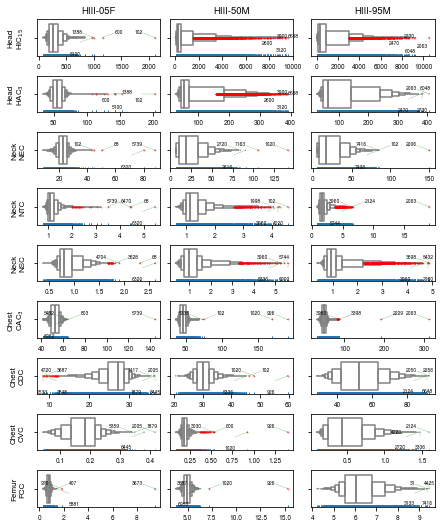

In [23]:
def box_and_rug():
    percs = [5, 50, 95]
    inj_names = INJURIES

    fig_width: float = WIDTH
    fig_height: float = 1.2*WIDTH

    fig, ax = plt.subplots(
        nrows=len(inj_names),
        ncols=len(percs),
        layout="constrained",
    )

    # plot
    versions = list(product(list(enumerate(inj_names)), list(enumerate(percs))))
    for (row, inj_val), (col, perc) in tqdm(versions):
        single_box_and_rug(inj_val=inj_val, perc=perc, ax=ax[row, col])
        ax[row, 0].set_ylabel(INJ_NAMES[inj_val].replace(" ", "\n"))
        ax[row, col].set_xlabel("")
        ax[0, col].set_title(f"HIII-{perc:02d}{'F' if perc == 5 else 'M'}")

    fig.align_ylabels(ax)
    fig.set_figheight(fig_height)
    fig.set_figwidth(fig_width)

    save_fig(fig=fig, f_name="injury_criteria_box_and_rug", close=False)


box_and_rug()

In [6]:
def plot_selection(n_largest: int = 10):
    inj2channels = {
        "Chest_Deflection": ["03CHST0000OCCUDSXD"],
        "Femur_Fz_Max_Compression": ["03FEMRRI00OCCUFOZD", "03FEMRLE00OCCUFOZD"],
        "Femur_Fz_Max_Tension": ["03FEMRRI00OCCUFOZD", "03FEMRLE00OCCUFOZD"],
        "Femur_Fz_Max": ["03FEMRRI00OCCUFOZD", "03FEMRLE00OCCUFOZD"],
        "Head_HIC15": ["03HEAD0000OCCUACXD", "03HEAD0000OCCUACYD", "03HEAD0000OCCUACZD", "03HEAD0000OCCUACRD"],
        "Head_HIC36": ["03HEAD0000OCCUACXD", "03HEAD0000OCCUACYD", "03HEAD0000OCCUACZD", "03HEAD0000OCCUACRD"],
        "Head_a3ms": ["03HEAD0000OCCUACXD", "03HEAD0000OCCUACYD", "03HEAD0000OCCUACZD", "03HEAD0000OCCUACRD"],
        "Chest_a3ms": ["03CHST0000OCCUACXD", "03CHST0000OCCUACYD", "03CHST0000OCCUACZD", "03CHST0000OCCUACRD"],
        "Neck_Fx_Shear_Max": ["03NECKUP00OCCUFOXD"],
        "Neck_Fz_Max_Tension": ["03NECKUP00OCCUFOZD"],
        "Neck_Fz_Max_Compression": ["03NECKUP00OCCUFOZD"],
        "Neck_My_Max": ["03NECKUP00OCCUMOYD"],
        "Neck_My_Extension": ["03NECKUP00OCCUMOYD"],
        "Neck_Nij": ["03NECKUP00OCCUMOYD", "03NECKUP00OCCUFOZD"],
    }
    WIDTH
    percs = [5, 50, 95]
    inj_names = sorted(set(pq.read_table(INJ_FPATH).schema.names) - {STR.perc, STR.id})
    versions = list(product(inj_names, percs))
    for inj_name, perc in tqdm(versions):
        if inj_name not in INJ_NAMES or inj_name not in inj2channels:
            continue
        db: pd.DataFrame = pd.read_parquet(INJ_FPATH, columns=[inj_name], filters=[(STR.perc, "==", perc)])[inj_name]
        ids = db.nlargest(n_largest).index.get_level_values(STR.id).to_list()

        channel_data = pd.read_parquet(
            DATA_DIR / "channels.parquet",
            columns=inj2channels[inj_name],
            filters=[(STR.id, "in", ids), (STR.perc, "==", perc)],
        ).sort_values(by=STR.time)

        fig, ax = plt.subplot_mosaic(
            mosaic=[["distro"] * len(inj2channels[inj_name]), sorted(inj2channels[inj_name])],
            # sharex="row",
            # sharey="row",
            layout="constrained",
            figsize=(WIDTH, 0.6*WIDTH),
            height_ratios=[0.2, 0.8],
        )
        fig.suptitle(f"{INJ_NAMES[inj_name]} - HIII {perc:02d} {'F' if perc == 5 else 'M'}")
        single_box_and_rug(inj_val=inj_name, perc=perc, ax=ax["distro"])
        ax["distro"].set_xlabel("")
        for ch in inj2channels[inj_name]:
            for idx in ids:
                f = channel_data.loc[(slice(None), idx), ch]
                ax[ch].plot(f.index.get_level_values(STR.time), f, label=int(idx))
            ax[ch].grid()
            ax[ch].set_ylabel(ch)
            ax[ch].set_xlabel(STR.time)
        ax[inj2channels[inj_name][-1]].legend()
        save_fig(fig=fig, f_name=f"{inj_name}_HIII{perc:02d}_{n_largest}_largest_channels")


plot_selection()

  0%|          | 0/48 [00:00<?, ?it/s]2024-10-27 08:15:35,111     INFO  MainProcess  MainThread maxp pruned
2024-10-27 08:15:35,116     INFO  MainProcess  MainThread cmap pruned
2024-10-27 08:15:35,118     INFO  MainProcess  MainThread post pruned
2024-10-27 08:15:35,120     INFO  MainProcess  MainThread CFF  pruned
2024-10-27 08:15:35,123     INFO  MainProcess  MainThread GPOS pruned
2024-10-27 08:15:35,132     INFO  MainProcess  MainThread GSUB pruned
2024-10-27 08:15:35,133     INFO  MainProcess  MainThread Added .notdef to subset
2024-10-27 08:15:35,135     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 20 glyphs before
2024-10-27 08:15:35,136     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'C', 'D', 'F', 'H', 'I', 'c', 'e', 'f', 'five', 'h', 'hyphen', 'i', 'l', 'n', 'o', 's', 'space', 't', 'zero']
2024-10-27 08:15:35,137     INFO  MainProcess  MainThread Glyph IDs:   [0, 43, 44, 47, 51, 55, 56, 57, 63, 64, 65, 66, 67, 73, 78, 82, 99, 104, 106, 122]
2024-1

In [10]:
DROPPED_IDS: Dict[int, List[int]] = {
    5: [68, 102, 600, 1388, 3673, 3687, 3848, 4720, 5100, 5665, 5733, 5739, 6320, 6802, 7533],
    50: [926, 1020],
    95: [2063, 2229, 2206],
}
json_util.dump(obj=DROPPED_IDS, f_path=DATA_DIR / STR.fname_dropped_ids)
DROPPED_IDS

{5: [68,
  102,
  600,
  1388,
  3673,
  3687,
  3848,
  4720,
  5100,
  5665,
  5733,
  5739,
  6320,
  6802,
  7533],
 50: [926, 1020],
 95: [2063, 2229, 2206]}

100%|██████████| 27/27 [00:05<00:00,  5.12it/s]
2025-01-04 12:10:42,816     INFO  MainProcess  MainThread maxp pruned
2025-01-04 12:10:42,838     INFO  MainProcess  MainThread cmap pruned
2025-01-04 12:10:42,839     INFO  MainProcess  MainThread kern dropped
2025-01-04 12:10:42,841     INFO  MainProcess  MainThread post pruned
2025-01-04 12:10:42,842     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 12:10:42,846     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 12:10:42,859     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 12:10:42,879     INFO  MainProcess  MainThread glyf pruned
2025-01-04 12:10:42,881     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 12:10:42,883     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 12:10:42,884     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 7 glyphs before
2025-01-04 12:10:42,885     INFO  MainProcess  MainThread Glyph names: ['.notdef', '.null', 'five', 'nonmarkingre

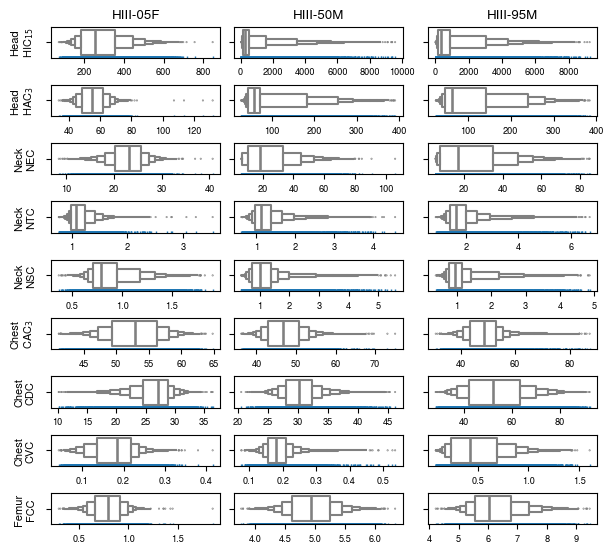

In [16]:
def box_and_rug_cleaned():
    percs = [5, 50, 95]
    inj_names = INJURIES

    fig_width: float = WIDTH
    fig_height: float = 0.9*WIDTH

    fig, ax = plt.subplots(
        nrows=len(inj_names),
        ncols=len(percs),
        layout="constrained",
    )

    # plot
    versions = list(product(list(enumerate(inj_names)), list(enumerate(percs))))
    for (row, inj_val), (col, perc) in tqdm(versions):
        single_box_and_rug(inj_val=inj_val, perc=perc, ax=ax[row, col], drop_ids=DROPPED_IDS)
        ax[row, 0].set_ylabel(INJ_NAMES[inj_val].replace(" ", "\n"))
        ax[row, col].set_xlabel("")
        ax[0, col].set_title(f"HIII-{perc:02d}{'F' if perc == 5 else 'M'}")

    fig.align_ylabels(ax)
    fig.set_figheight(fig_height)
    fig.set_figwidth(fig_width)
    save_fig(fig=fig, f_name="injury_criteria_box_and_rug_cleaned", close=False)


box_and_rug_cleaned()

In [9]:
def plot_dropped_grid():
    # get data
    doe = pd.read_parquet(DOE_FPATH)
    factors = sorted(doe.columns)
    parser = pd.read_parquet(SIMID2ID_FPATH).reset_index().set_index([STR.id, STR.perc])

    # plot
    fig, ax = plt.subplots(
        ncols=doe.shape[1],
        nrows=doe.shape[1] + 1,
        figsize=(WIDTH, WIDTH),
        sharex="col",
        sharey="row",
        layout="constrained",
        height_ratios=[0.1] + [1] * doe.shape[1],
    )
    gs = ax[0, 0].get_gridspec()
    for a in ax[0]:
        a.remove()
    axbig = fig.add_subplot(gs[0, :])
    axbig.axis("off")

    for i, x_axis in enumerate(factors):
        for j, y_axis in enumerate(factors):
            ax[i + 1, j].scatter(doe[y_axis], doe[x_axis], color="b", label="DoE", s=0.05)

            for q, perc in enumerate(DROPPED_IDS.keys()):
                locs = parser.loc[(DROPPED_IDS[perc], perc), :].values.flatten()
                ax[i + 1, j].scatter(
                    doe.loc[locs, y_axis],
                    doe.loc[locs, x_axis],
                    color="r",
                    label=f"Dropped HIII{perc:02d}{'F' if perc == 5 else 'M'}  n={len(DROPPED_IDS[perc])}",
                    marker=["+", "x", "*"][q],
                )
            ax[i + 1, j].grid()
            ax[i + 1, j].set_axisbelow(True)

    for i, label in enumerate(factors):
        ax[-1, i].set_xlabel(label)
        ax[i + 1, 0].set_ylabel(label)
    axbig.legend(*ax[-1, -1].get_legend_handles_labels(), ncols=4, loc="center")

    save_fig(fig=fig, f_name="doe_dropped_ids")


plot_dropped_grid()

2024-10-27 08:17:21,822     INFO  MainProcess  MainThread maxp pruned
2024-10-27 08:17:21,827     INFO  MainProcess  MainThread cmap pruned
2024-10-27 08:17:21,828     INFO  MainProcess  MainThread post pruned
2024-10-27 08:17:21,830     INFO  MainProcess  MainThread CFF  pruned
2024-10-27 08:17:21,832     INFO  MainProcess  MainThread GPOS pruned
2024-10-27 08:17:21,843     INFO  MainProcess  MainThread GSUB pruned
2024-10-27 08:17:21,844     INFO  MainProcess  MainThread Added .notdef to subset
2024-10-27 08:17:21,845     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 44 glyphs before
2024-10-27 08:17:21,846     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'L', 'M', 'P', 'R', 'S', 'T', 'V', 'X', 'a', 'c', 'd', 'e', 'eight', 'equal', 'five', 'four', 'g', 'l', 'minus', 'n', 'nine', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'underscore', 'zero']
2024-10-27 08:17:21,847     INFO  MainP

In [10]:
def plot_bars(point_db: pd.DataFrame, fig_title: str, store: bool = True, sort_by_all: bool = True) -> None:
    if sort_by_all:
        existing_points = [str(x) for x in sorted(set(point_db.to_numpy().flatten()))]
    percs = sorted(point_db.index.get_level_values(STR.perc).unique())

    for perc in percs:
        for idx in DROPPED_IDS[perc]:
            try:
                point_db.drop(index=[idx, perc], inplace=True)
            except KeyError:
                LOG.warning("Could not drop index %s of perc %s", idx, perc)

    fig_width: float = WIDTH
    fig_height: float = 0.7 * fig_width
    fig, ax = plt.subplots(
        ncols=point_db.shape[1],
        nrows=len(percs),
        figsize=(fig_width, fig_height),
        sharex=True,
        sharey=True if sort_by_all else "row",
        layout="constrained",
    )
    fig.suptitle(fig_title)
    vers = list(product(list(enumerate(point_db.columns)), list(enumerate(percs))))
    for (col, val), (row, perc) in vers:
        if not sort_by_all:
            existing_points = [
                str(x)
                for x in sorted(
                    set(point_db.loc[(slice(None), perc), val].to_numpy().flatten()), key=lambda x: int(x.split(":")[0])
                )
            ]
        cnt = [str(x) for x in point_db.loc[(slice(None), perc), val].to_list()]
        sns.countplot(
            cnt,
            ax=ax[row, col],
            order=existing_points,
            alpha=0.5,
            native_scale=False,
        )
        ax[0, col].set_title(val, size="x-small")
        ax[row, 0].set_ylabel(f"HIII{perc:02} - n={len(cnt)}")
        ax[row, col].set_xlim([0, 9000])
        ax[row, col].bar_label(ax[row, col].containers[0], fontsize=7, rotation=90, padding=2)
    if store:
        save_fig(fig=fig, f_name=f"{'_'.join(fig_title.lower().split())}_distribution_bars")


plot_bars(
    point_db=pd.concat(
        [LoadForClassification(data_directory=DATA_DIR).injury_value_to_points(percentile=perc) for perc in (5, 95)], axis=0
    ),
    fig_title="Points by Euro NCAP",
    store=True,
)

2024-10-27 08:17:21,976     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200' exists
2024-10-27 08:17:21,979     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists
2024-10-27 08:17:21,980     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200/results_info.json' exists
2024-10-27 08:17:22,103     INFO  MainProcess  MainThread Hashes of injury files are the same
2024-10-27 08:17:22,349     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200' exists
2024-10-27 08:17:22,350     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists
2024-10-27 08:17:22,351     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200/results_info.json' exists
2024-10-27 08:17:22,

In [11]:
def plot_classes(n_classes: int):
    LOG.info("Plotting classes with %s classes", n_classes)
    db = pd.read_parquet(CLASSES_FPATHS[n_classes])
    db = pd.concat([db.loc[(slice(None), perc), :].replace(RENAMER[perc][n_classes]) for perc in (5, 95)], axis=0)

    plot_bars(point_db=db, fig_title=f"Classification with {n_classes} Classes", store=True, sort_by_all=False)


_ = [plot_classes(n_classes=n_classes) for n_classes in CLASSES_FPATHS.keys()]

2024-10-27 08:17:26,915     INFO  MainProcess  MainThread Plotting classes with 2 classes
/tmp/ipykernel_3461754/3553979003.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  point_db.drop(index=[idx, perc], inplace=True)
2024-10-27 08:17:26,965  WARNING  MainProcess  MainThread Could not drop index 102 of perc 5.0
2024-10-27 08:17:26,966  WARNING  MainProcess  MainThread Could not drop index 600 of perc 5.0
2024-10-27 08:17:26,968  WARNING  MainProcess  MainThread Could not drop index 1388 of perc 5.0
2024-10-27 08:17:26,970  WARNING  MainProcess  MainThread Could not drop index 3673 of perc 5.0
2024-10-27 08:17:26,971  WARNING  MainProcess  MainThread Could not drop index 3687 of perc 5.0
2024-10-27 08:17:26,972  WARNING  MainProcess  MainThread Could not drop index 3848 of perc 5.0
2024-10-27 08:17:26,973  WARNING  MainProcess  MainThread Could not drop index 4720 of perc 5.0
2024-10-27 08:17:26,974  WARNING  MainPro